<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#分析LTEPAT输出结果" data-toc-modified-id="分析LTEPAT输出结果-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>分析LTEPAT输出结果</a></span><ul class="toc-item"><li><span><a href="#导入相关程序库" data-toc-modified-id="导入相关程序库-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导入相关程序库</a></span></li><li><span><a href="#读取文件" data-toc-modified-id="读取文件-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>读取文件</a></span></li><li><span><a href="#分析Excel中指定counter和kpi的数据" data-toc-modified-id="分析Excel中指定counter和kpi的数据-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>分析Excel中指定counter和kpi的数据</a></span><ul class="toc-item"><li><span><a href="#整理合并Sheet中的Counter和KPI数据" data-toc-modified-id="整理合并Sheet中的Counter和KPI数据-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>整理合并Sheet中的Counter和KPI数据</a></span></li></ul></li><li><span><a href="#处理counter-dataframe中指定的counter" data-toc-modified-id="处理counter-dataframe中指定的counter-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>处理counter dataframe中指定的counter</a></span></li><li><span><a href="#其他功能" data-toc-modified-id="其他功能-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>其他功能</a></span><ul class="toc-item"><li><span><a href="#用字典形式存储所有Counter的ID和对应的名字" data-toc-modified-id="用字典形式存储所有Counter的ID和对应的名字-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>用字典形式存储所有Counter的ID和对应的名字</a></span></li><li><span><a href="#整理数据（填充NA值，标准化数据，特征选择）" data-toc-modified-id="整理数据（填充NA值，标准化数据，特征选择）-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>整理数据（填充NA值，标准化数据，特征选择）</a></span></li><li><span><a href="#计算相关系数" data-toc-modified-id="计算相关系数-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>计算相关系数</a></span></li></ul></li></ul></li></ul></div>

### 分析LTEPAT输出结果

#### 导入相关程序库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import re
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#### 读取文件

In [2]:
# 这里的excel文件是LTEPAT处理eNB Snapshot中的PM文件后的输出文件
file_path = r"D:\userdata\anliu\Desktop\log\IRAN\150918\DT2828"
file_name = r"201809142132_PMOutput.xlsx"

os.chdir(file_path)

file = os.path.join(file_path, file_name)
xls = pd.ExcelFile(file)

#### 分析Excel中指定counter和kpi的数据

##### 整理合并Sheet中的Counter和KPI数据

In [3]:
# LTE counter所在的sheet列表
counter_sheet = [
    'LTE_Inter_eNB_via_S1_Handover', 'LTE_Inter_eNB_via_X2_Handover', 'LTE_VoLTE_Voice_Break_Period_Hi',
    'LTE_M_per_LNCEL', 'LTE_Broadcast', 'LTE_Received_Interference_Power', 'LTE_VoLTE_BLER_Histogram',
    'LTE_RSRP_and_RSRQ_Histogram', 'LTE_UE_Quantity', 'LTE_Mobility_Events', 'LTE_SINR', 'LTE_MBMS', 'LTE_MAC',
    'LTE_HO_RLF_trigger', 'LTE_QoS', 'LTE_UE_and_ServDiff', 'LTE_Handover', 'LTE_Cell_Avail', 'LTE_Inter_Sys_HO',
    'LTE_Inter_eNB_HO', 'LTE_UE_State', 'LTE_Cell_Throughput', 'LTE_Cell_Resource', 'LTE_Pwr_and_Qual_DL',
    'LTE_Intra_eNB_HO', 'LTE_RRC', 'LTE_Radio_Bearer', 'LTE_EPS_Bearer', 'LTE_Pwr_and_Qual_UL', 'LTE_Cell_Load'
]

# LTE KPI所在的sheet列表
kpi_sheet = [
    'KPIs_WBTS_TTIB', 'KPIs_WBTS_CELL OTHER', 'KPIs_WBTS_CELL USAGE', 'KPIs_WBTS_ENB INTEGRITY',
    'KPIs_WBTS_CELL INTEGRITY', 'KPIs_WBTS_CELL USAGE USERS', 'KPIs_WBTS_ENB RETAINABILITY',
    'KPIs_WBTS_ENB USAGE', 'KPIs_WBTS_CELL MOBILITY', 'KPIs_WBTS_CELL RETAINABILITY',
    'KPIs_WBTS_CELL ACCESSIBILITY'
]

# 整理每张sheet的数据，包括读取数据，合并列，去除无效值和不需要的列
def sheet_data_clean_up(sheet):
    sheet_data = xls.parse(sheet)
    # 去除sheet中最后几列的统计数据
    sheet_data = sheet_data[~sheet_data['StartDate'].astype(str).str.startswith('System Level')]
    # 去除所有值都是NA的行和列
    sheet_data.dropna(how='all', axis=1, inplace=True)
    sheet_data.dropna(how='all', axis=0, inplace=True)  
    # 将日期和时间列合并为Time列，删除baseId列，删除localMoid为空的行
    Time = sheet_data.StartDate.astype(str) + ' ' + sheet_data.StartTime.astype(str)
    sheet_data = sheet_data[~sheet_data['localMoid'].isnull()]    
    sheet_data['Time'] = pd.to_datetime(Time)
    sheet_data.drop(axis=1, columns=['StartDate', 'StartTime', 'baseId'], inplace=True)  
    
    return sheet_data

# 合并所有LTE分类sheet的数据
from functools import reduce
def get_category_data(xls, cat_sheet):
    cat_list = []
    for sheet in cat_sheet:
        sheet_data = sheet_data_clean_up(sheet)
        print(sheet, len(sheet_data))
        cat_list.append(sheet_data)
    
    # 合并分类列表并按Time和localMoid排序
    cat_data = reduce(lambda left,right: pd.merge(left,right,on=['Time', 'localMoid'], how='outer'), cat_list)
    cat_data.sort_values(['Time', 'localMoid'], inplace=True)
        
    return cat_data

# 最终数据统计以小区为单位，这里只提取小区对应的数据，去掉其他比如bts级别的数据
def select_data(data):
    p = r'DN\:NE-LNBTS-\d+/LNCEL-\d+/MCC-\d+/MNC-\d+$'
    cells = [i for l in data['localMoid'].unique() for i in re.findall(p, l) if i!=[]]
    data = data[data['localMoid'].isin(cells)]   
    
    return data

In [4]:
counter_data = get_category_data(xls, counter_sheet)
counter_data = select_data(counter_data)

kpi_data = get_category_data(xls, kpi_sheet)
kpi_data = select_data(kpi_data)

LTE_Inter_eNB_via_S1_Handover 72
LTE_Inter_eNB_via_X2_Handover 72
LTE_VoLTE_Voice_Break_Period_Hi 72
LTE_M_per_LNCEL 72
LTE_Broadcast 72
LTE_Received_Interference_Power 72
LTE_VoLTE_BLER_Histogram 72
LTE_RSRP_and_RSRQ_Histogram 72
LTE_UE_Quantity 72
LTE_Mobility_Events 72
LTE_SINR 72
LTE_MBMS 72
LTE_MAC 72
LTE_HO_RLF_trigger 72
LTE_QoS 72
LTE_UE_and_ServDiff 72
LTE_Handover 72
LTE_Cell_Avail 72
LTE_Inter_Sys_HO 72
LTE_Inter_eNB_HO 72
LTE_UE_State 72
LTE_Cell_Throughput 72
LTE_Cell_Resource 72
LTE_Pwr_and_Qual_DL 72
LTE_Intra_eNB_HO 72
LTE_RRC 72
LTE_Radio_Bearer 72
LTE_EPS_Bearer 72
LTE_Pwr_and_Qual_UL 72
LTE_Cell_Load 72
KPIs_WBTS_TTIB 72
KPIs_WBTS_CELL OTHER 72
KPIs_WBTS_CELL USAGE 216
KPIs_WBTS_ENB INTEGRITY 72
KPIs_WBTS_CELL INTEGRITY 120
KPIs_WBTS_CELL USAGE USERS 72
KPIs_WBTS_ENB RETAINABILITY 96
KPIs_WBTS_ENB USAGE 169
KPIs_WBTS_CELL MOBILITY 144
KPIs_WBTS_CELL RETAINABILITY 96
KPIs_WBTS_CELL ACCESSIBILITY 96


In [5]:
print(counter_data.shape)
print(kpi_data.shape)
data_all = pd.merge(kpi_data, counter_data, on=['Time', 'localMoid'])

(72, 2982)
(72, 700)


#### 处理counter dataframe中指定的counter

In [6]:
iot = [
       'M8005C317:UL_IOT_PUSCH_DIST_BIN_0 (1.0E-1 dB)', 'M8005C318:UL_IOT_PUSCH_DIST_BIN_1 (1.0E-1 dB)',
       'M8005C319:UL_IOT_PUSCH_DIST_BIN_2 (1.0E-1 dB)', 'M8005C320:UL_IOT_PUSCH_DIST_BIN_3 (1.0E-1 dB)',
       'M8005C321:UL_IOT_PUSCH_DIST_BIN_4 (1.0E-1 dB)', 'M8005C322:UL_IOT_PUSCH_DIST_BIN_5 (1.0E-1 dB)',
       'M8005C323:UL_IOT_PUSCH_DIST_BIN_6 (1.0E-1 dB)', 'M8005C324:UL_IOT_PUSCH_DIST_BIN_7 (1.0E-1 dB)',
       'M8005C325:UL_IOT_PUSCH_DIST_BIN_8 (1.0E-1 dB)', 
#        'M8005C233:RSSI_CELL_PUSCH_MEAN (dBm)', 'M8005C283:SINR_CELL_PUSCH_MEAN (dB)'
      ]

# 仅保留需要处理的columns
def data_crop(data, cols):
    data_crop = pd.concat([data[['Time', 'localMoid']], data[cols]], axis=1)
    # 取消数据中cols列全部为NA值的列
    data_crop.dropna(subset=cols, how='all', inplace=True)
    
    return data_crop

data_iot = data_crop(counter_data, iot)

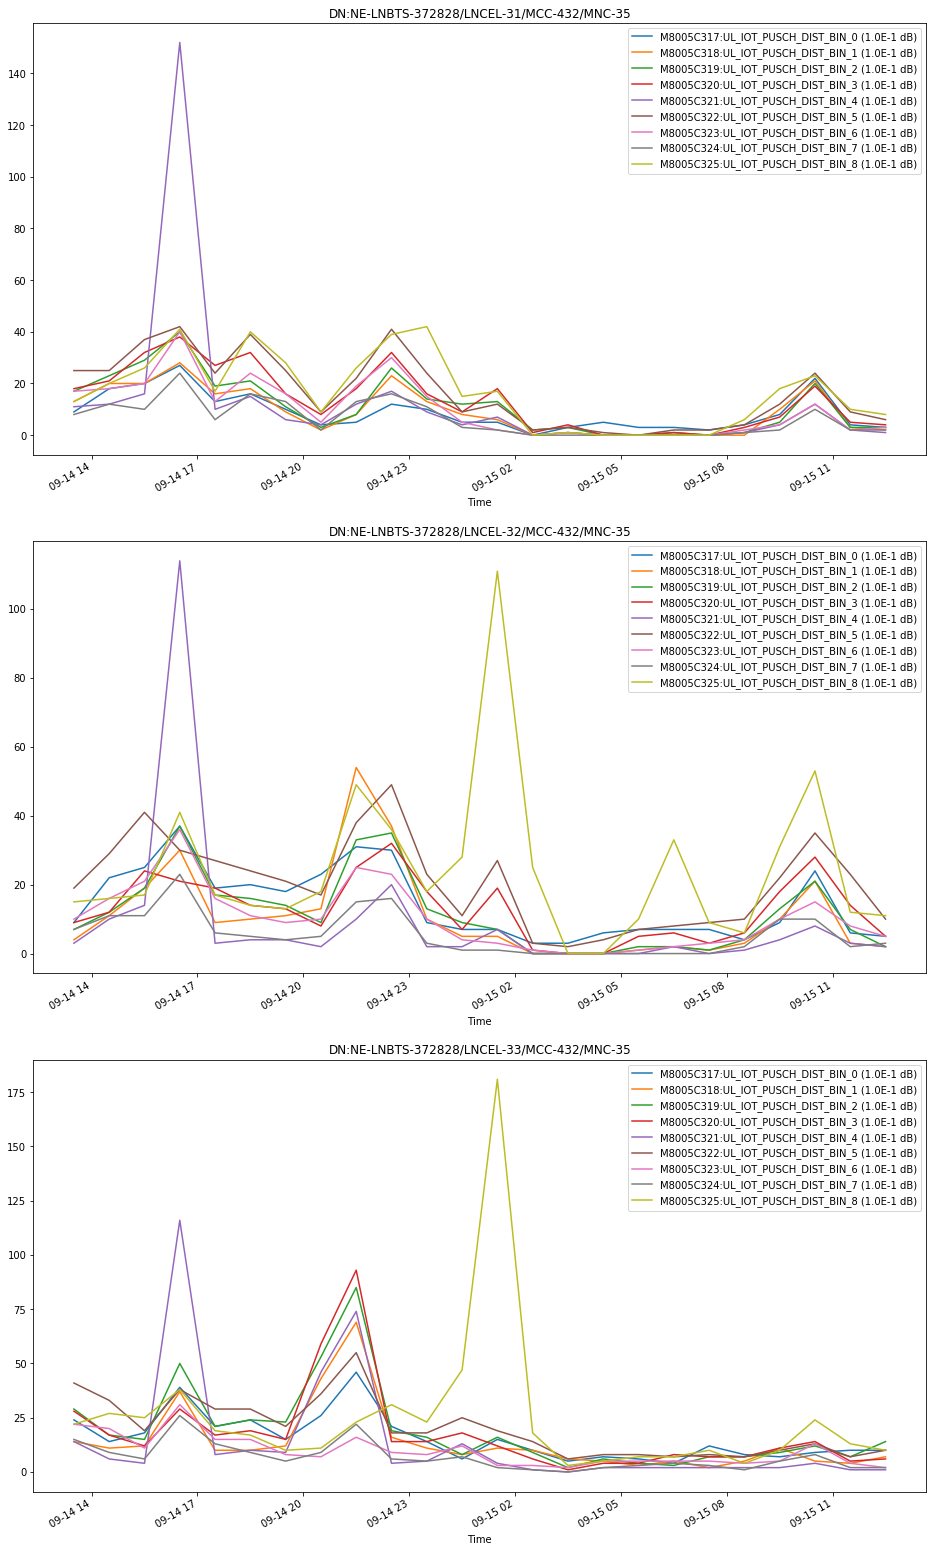

In [7]:
# counter数据可视化
def visual_data(data):
    grouped_by_cell = data.groupby('localMoid')
    # grouped_by_cell.plot(x='Time', y=data_iot.columns[3:12], kind="line", figsize=(16,8))
    fig = plt.figure(figsize=(16,10*len(grouped_by_cell)))
    n = len(grouped_by_cell)
    for i, (name, group) in enumerate(grouped_by_cell):
        ax = fig.add_subplot(n, 1, i+1)
        group.plot(x='Time', y=group.columns[2:], ax=ax, title=name)    
#         days = mdates.DayLocator(interval=1)
#         hours = mdates.HourLocator(interval=6)
#         ax.xaxis.set_major_locator(days)
#         ax.xaxis.set_minor_locator(hours)
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
#         ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
#         ax.tick_params(pad=10)
#         ax.legend(loc='lower left', bbox_to_anchor=(0.1, 0.3))
        ax.xaxis.set_label_coords(0.5, -0.1)
    plt.savefig('IoT.jpg')
    
visual_data(data_iot)

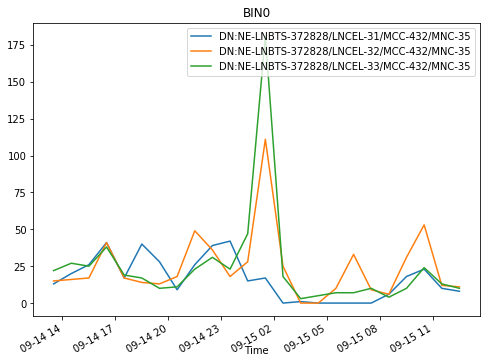

In [8]:
# 比较不同localMoid的同一列数据
grouped_by_cell = data_iot.groupby('localMoid')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for i, (name, group) in enumerate(grouped_by_cell):
    group.plot(x='Time', y=group.columns[10], ax=ax, title='BIN0', label=name)
    ax.xaxis.set_label_coords(0.5, -0.1)

#### 其他功能

##### 用字典形式存储所有Counter的ID和对应的名字

In [9]:
def get_counter_name(xls):
    counters = {}
    for sheet in xls.sheet_names:
        if not sheet.startswith('KPI') and not sheet.startswith('Summary') :
            sheet_data = xls.parse(sheet)
            sheet_data.dropna(how='all', axis=1, inplace=True)
            sheet_data.dropna(how='all', axis=0, inplace=True)            
            sheet_cols = sheet_data.columns.tolist()[4:]
            
            for col in sheet_cols:
                cid = col.split(':')[0]
                name = col.split(':')[1]
                counters[cid] = name

    return counters

# counter_all = get_counter_name(xls)

# 将字典内容写入到文件
# outfile = r"D:\userdata\anliu\Desktop\log\IRAN\Snapshot_MRBTS-371324\test.txt"
# with open(outfile, 'w+') as out:
#     for key in counters:
#         out.writelines((key + ',' + counters[key] + '\n'))

##### 整理数据（填充NA值，标准化数据，特征选择）

In [10]:
# 如果某些列不全部都是NA值，使用中位数填充NA值
from sklearn.preprocessing import Imputer
def fill_na_data(data):
    # print(np.where(data.isnull()))
    imputer = Imputer(strategy='median')
    imputer.fit(data)
    X = imputer.transform(data)
    # imputer只对数据处理，会删除column和index name，转化为dataframe需要重新添加column name和index name
    data = pd.DataFrame(X, columns=data.columns, index=data.index)
    # np.where(data.isnull())
    
    return data

# 标准化数据
'''StandardScaler method subtracts the mean value and then it divides by the variance so that the resulting
distribution has unit variance. Standardization does not bound values to a specific range, which may be a problem for 
some algorithms (e.g. neural networks often expect an input value ranging from 0 to 1). However, standardization
is much less affected by outliers.
'''
from sklearn.preprocessing import StandardScaler
def data_scale(data):
    ss = StandardScaler()
    X = ss.fit_transform(data)
    data = pd.DataFrame(X, columns=data.columns, index=data.index)
    
    return data

# 特征选择
from sklearn.feature_selection import VarianceThreshold
# 方差选择，返回值为特征选择后的数据
# 参数threshold为方差的阈值
def variance_selection(data):
    sel = VarianceThreshold(threshold=0) #去掉那些方差等于0的值
    X = sel.fit_transform(data)
    feat_mask = sel.get_support() # Get a mask, or integer index, of the features selected
    # 保留mask值为1的特征
    columns = [data.columns[i] for i, e in enumerate(feat_mask) if e]
    data = pd.DataFrame(X, columns=columns, index=data.index)
    
    return data

In [11]:
data_all['localMoid'].unique()

array(['DN:NE-LNBTS-372828/LNCEL-31/MCC-432/MNC-35',
       'DN:NE-LNBTS-372828/LNCEL-32/MCC-432/MNC-35',
       'DN:NE-LNBTS-372828/LNCEL-33/MCC-432/MNC-35'], dtype=object)

In [12]:
data_cell = data_all[data_all['localMoid']=='DN:NE-LNBTS-372828/LNCEL-31/MCC-432/MNC-35']
data_cell = data_cell.drop(['localMoid'], axis=1)
data_cell.set_index('Time', inplace=True)

In [13]:
data_cell.dropna(axis=1, how='all', inplace=True)
data_cell = fill_na_data(data_cell)
data_cell_scale = data_scale(data_cell)
data_cell_select = variance_selection(data_cell_scale)

In [14]:
print(data_cell_scale.shape)
print(data_cell_select.shape)

(24, 3647)
(24, 1451)


##### 计算相关系数

In [15]:
data_corr = data_cell_select.corr()

In [16]:
def calc_corr(data, col, threshold):
    print(data[abs(data[col])>threshold][col])
    
calc_corr(data_corr, 'LTE_1553a Block error ratio (BLER) in UL (%)', 0.8)

LTE_140b Perc UL_SCH TB RTRANS (%)               0.838391
LTE_1553a Block error ratio (BLER) in UL (%)     1.000000
M8031C147:DL_SINR_DIST_SB8_BIN7                  0.885017
M8031C167:DL_SINR_DIST_SB9_BIN7                  0.901565
M8031C227:DL_SINR_DIST_SB12_BIN7                 0.859792
M8010C92:MIMO_FALLBACK_TXDIV                     0.863350
M8005C321:UL_IOT_PUSCH_DIST_BIN_4 (1.0E-1 dB)    0.933407
M8001C74:PUSCH_TRANS_NACK_MCS0                   0.953199
M8001C177:TB_BAD_PUSCH_MCS0                      0.961928
M8001C178:TB_BAD_PUSCH_MCS1                      0.862231
M8001C179:TB_BAD_PUSCH_MCS2                      0.908962
M8001C181:TB_BAD_PUSCH_MCS4                      0.913200
M8001C183:TB_BAD_PUSCH_MCS6                      0.921442
M8001C184:TB_BAD_PUSCH_MCS7                      0.851678
M8001C185:TB_BAD_PUSCH_MCS8                      0.928411
M8001C186:TB_BAD_PUSCH_MCS9                      0.878625
M8001C187:TB_BAD_PUSCH_MCS10                     0.883701
M8001C188:TB_B